In [1]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import nltk
import os

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kirta\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kirta\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kirta\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kirta\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kirta\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [4]:
lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))

In [5]:
def process_requirement_text(text):
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower().split()
    review = [
        lemmatizer.lemmatize(word) if not word.isdigit() else word
        for word in review
        if word not in english_stopwords
    ]
    return ' '.join(review)

In [21]:
import pandas as pd

def read_requirements_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            parts = line.split(':', 1)
            if len(parts) == 2:
                data.append(parts)
            else:
                print(f"Skipping malformed line: {line}")
    return data

data_nfr = read_requirements_file('datasets/nfr.txt')
data_dup = read_requirements_file('datasets/nfr dup.txt')

df_nfr = pd.DataFrame(data_nfr, columns=["class", "requirement"])
df_dup = pd.DataFrame(data_dup, columns=["class", "requirement"])

df = pd.concat([df_nfr, df_dup], ignore_index=True)

df['RequirementText'] = df['requirement'].apply(process_requirement_text)

print(df.head())

  class                                        requirement  \
0    PE  The system shall refresh the display every 60 ...   
1    LF  The application shall match the color of the s...   
2    US   If projected  the data must be readable.  On ...   
3     A   The product shall be available during normal ...   
4    US   If projected  the data must be understandable...   

                                     RequirementText  
0          system shall refresh display every second  
1  application shall match color schema set forth...  
2  projected data must readable x projection scre...  
3  product shall available normal business hour l...  
4  projected data must understandable x projectio...  


In [22]:
df

,class,requirement,RequirementText
0,PE,The system shall refresh the display every 60 ...,system shall refresh display every second
1,LF,The application shall match the color of the s...,application shall match color schema set forth...
2,US,If projected the data must be readable. On ...,projected data must readable x projection scre...
3,A,The product shall be available during normal ...,product shall available normal business hour l...
4,US,If projected the data must be understandable...,projected data must understandable x projectio...
...,...,...,...
669,O,The system will integrate with multiple datab...,system integrate multiple database management ...
670,O,The system must be installable in any operati...,system must installable operating environment ...
671,SE,The system will ensure that only company empl...,system ensure company employee approved extern...
672,SE,Only managers will be able to perform search ...,manager able perform search query reservation ...


In [23]:
classes = ['F', 'A', 'L', 'LF', 'MN', 'O', 'PE', 'SC', 'SE', 'US', 'FT', 'PO']

def get_counts(df, class_col_name):
    return df[class_col_name].value_counts().reindex(classes, fill_value=0).to_dict()

nfr_counts = get_counts(df, 'class')

print(nfr_counts)

output_dir = '/content/sample_data'
os.makedirs(output_dir, exist_ok=True)

df.to_csv(os.path.join(output_dir, 'dataset_normalized.csv'), sep=',', header=True, index=False, quotechar='"', doublequote=True)

{'F': 238, 'A': 25, 'L': 16, 'LF': 40, 'MN': 21, 'O': 82, 'PE': 61, 'SC': 27, 'SE': 67, 'US': 83, 'FT': 11, 'PO': 3}


In [24]:
df=pd.read_csv('/content/sample_data/dataset_normalized.csv')

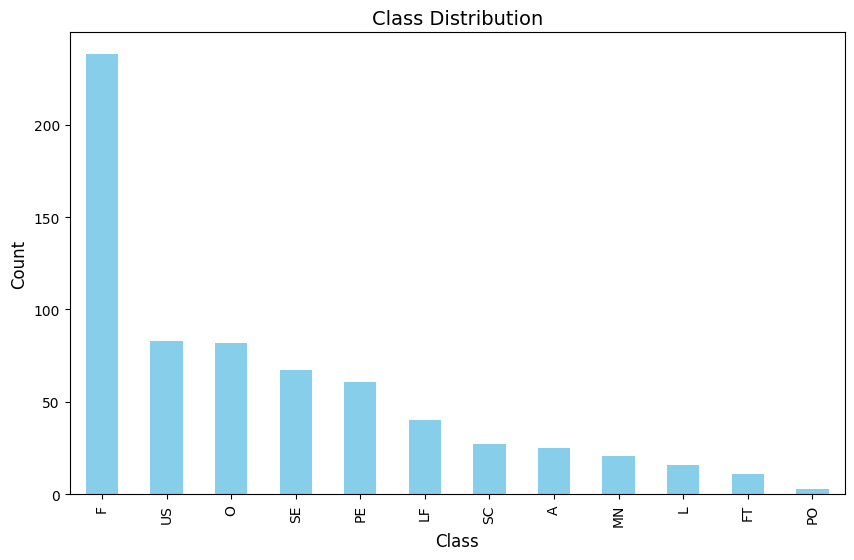

In [25]:
import matplotlib.pyplot as plt
class_counts = df['class'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')

plt.title('Class Distribution', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

corpus = df['RequirementText'].tolist()
cv = CountVectorizer(binary=True)
X_bow = cv.fit_transform(corpus).toarray()

np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
print(X_bow)

print(cv.vocabulary_)

sorted_vocab_keys = sorted(cv.get_feature_names_out())
bow_df = pd.DataFrame(X_bow, columns=sorted_vocab_keys)
print("Vocabulary columns:", sorted_vocab_keys)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
df['SimilarRequirement'] = None

for i in range(len(df)):
    similar_reqs = []

    for j in range(i + 1, len(df)):
        cosine_sim = cosine_similarity([X_bow[i]], [X_bow[j]])[0][0]

        if cosine_sim > 0.8:
            similar_reqs.append(f"{df['RequirementText'][j]} ({j})")

    if similar_reqs:
        df.at[i, 'SimilarRequirement'] = ', '.join(similar_reqs)

print(df[['class', 'RequirementText', 'SimilarRequirement']])

    class                                    RequirementText  \
0      PE          system shall refresh display every second   
1      LF  application shall match color schema set forth...   
2      US  projected data must readable x projection scre...   
3       A  product shall available normal business hour l...   
4      US  projected data must understandable x projectio...   
..    ...                                                ...   
669     O  system integrate multiple database management ...   
670     O  system must installable operating environment ...   
671    SE  system ensure company employee approved extern...   
672    SE  manager able perform search query reservation ...   
673    SE  system ensure database data corresponds exactl...   

                                    SimilarRequirement  
0            system refresh display every second (556)  
1    application shall match color schema set forth...  
2    projected data must legible x projection scree...  
3  

In [ ]:
df['SimilarRequirement'].count()

63

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(corpus).toarray()

sorted_vocab_keys = sorted(tfidf.get_feature_names_out())
print(X_tfidf)

tfidf_df = pd.DataFrame(X_tfidf, columns=sorted_vocab_keys)

tfidf_df.to_csv('/content/sample_data/dataset_tfidf_sorted.csv', index=False)
print(tfidf.vocabulary_)
print("Vocabulary columns:", sorted_vocab_keys)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0.145 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.239 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0.181 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0.14 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.231 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0.165 0 0 0 0 0.205 0.314 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0.174 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.286 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.188 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
df['SimilarRequirement'] = None

for i in range(len(df)):
    similar_reqs = []

    for j in range(i + 1, len(df)):
        cosine_sim = cosine_similarity([X_tfidf[i]], [X_tfidf[j]])[0][0]

        if cosine_sim > 0.8:
            similar_reqs.append(f"{df['RequirementText'][j]} ({j})")

    if similar_reqs:
        df.at[i, 'SimilarRequirement'] = ', '.join(similar_reqs)

print(df[['class', 'RequirementText', 'SimilarRequirement']])

    class                                    RequirementText  \
0      PE  the system shall refresh the display every  se...   
1      LF  the application shall match the color of the s...   
2      US   if projected  the data must be readable  on a...   
3       A   the product shall be available during normal ...   
4      US   if projected  the data must be understandable...   
..    ...                                                ...   
669     O   the system will integrate with multiple datab...   
670     O   the system must be installable in any operati...   
671    SE   the system will ensure that only company empl...   
672    SE   only managers will be able to perform search ...   
673    SE   the system will ensure that the databases dat...   

                                    SimilarRequirement  
0     the system will refresh the display every  se...  
1     the application shall match the color schema ...  
2     if projected the data must be legible on a x ...  
3  

In [ ]:
df['SimilarRequirement'].count()

55

In [ ]:
def jaccard_similarity(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

df['SimilarRequirement'] = None

for i in range(len(df)):
    similar_reqs = []

    for j in range(i + 1, len(df)):
        jaccard_sim = jaccard_similarity(df['RequirementText'][i], df['RequirementText'][j])

        if jaccard_sim > 0.6:
            similar_reqs.append(f"{df['RequirementText'][j]} ({j})")

    if similar_reqs:
        df.at[i, 'SimilarRequirement'] = ', '.join(similar_reqs)

print(df[['class', 'RequirementText', 'SimilarRequirement']])

    class                                    RequirementText  \
0      PE          system shall refresh display every second   
1      LF  application shall match color schema set forth...   
2      US  projected data must readable x projection scre...   
3       A  product shall available normal business hour l...   
4      US  projected data must understandable x projectio...   
..    ...                                                ...   
669     O  system integrate multiple database management ...   
670     O  system must installable operating environment ...   
671    SE  system ensure company employee approved extern...   
672    SE  manager able perform search query reservation ...   
673    SE  system ensure database data corresponds exactl...   

                                    SimilarRequirement  
0            system refresh display every second (556)  
1    application shall match color schema set forth...  
2    projected data must understandable x projectio...  
3  

In [ ]:
df['SimilarRequirement'].count()

99

In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean

df['SimilarRequirement'] = None

for i in range(len(df)):
    similar_reqs = []

    for j in range(i + 1, len(df)):
        euclidean_dist = euclidean(X_bow[i], X_bow[j])
        if euclidean_dist < 0.5:
            similar_reqs.append(f"{df['RequirementText'][j]} ({j})")

    if similar_reqs:
        df.at[i, 'SimilarRequirement'] = ', '.join(similar_reqs)

print(df[['class', 'RequirementText', 'SimilarRequirement']])

    class                                    RequirementText  \
0      PE  the system shall refresh the display every  se...   
1      LF  the application shall match the color of the s...   
2      US   if projected  the data must be readable  on a...   
3       A   the product shall be available during normal ...   
4      US   if projected  the data must be understandable...   
..    ...                                                ...   
669     O   the system will integrate with multiple datab...   
670     O   the system must be installable in any operati...   
671    SE   the system will ensure that only company empl...   
672    SE   only managers will be able to perform search ...   
673    SE   the system will ensure that the databases dat...   

                                    SimilarRequirement  
0                                                 None  
1     the application shall match the color schema ...  
2                                                 None  
3  

In [ ]:
df['SimilarRequirement'].count()

6

In [ ]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.9 MB/s eta 0:00:00


In [ ]:
import Levenshtein as lev

df['SimilarRequirement'] = None

for i in range(len(df)):
    similar_reqs = []

    for j in range(i + 1, len(df)):
        levenshtein_dist = lev.distance(df['RequirementText'][i], df['RequirementText'][j])
        if levenshtein_dist < 5:
            similar_reqs.append(f"{df['RequirementText'][j]} ({j})")

    if similar_reqs:
        df.at[i, 'SimilarRequirement'] = ', '.join(similar_reqs)

print(df[['class', 'RequirementText', 'SimilarRequirement']])

    class                                    RequirementText  \
0      PE  the system shall refresh the display every  se...   
1      LF  the application shall match the color of the s...   
2      US   if projected  the data must be readable  on a...   
3       A   the product shall be available during normal ...   
4      US   if projected  the data must be understandable...   
..    ...                                                ...   
669     O   the system will integrate with multiple datab...   
670     O   the system must be installable in any operati...   
671    SE   the system will ensure that only company empl...   
672    SE   only managers will be able to perform search ...   
673    SE   the system will ensure that the databases dat...   

                                    SimilarRequirement  
0     the system will refresh the display every  se...  
1                                                 None  
2                                                 None  
3  

In [ ]:
df['SimilarRequirement'].count()

12

In [ ]:
import gensim.downloader as api
from gensim.models import KeyedVectors
import pandas as pd

word_vectors = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
import pandas as pd
import numpy as np
import re
import gensim.downloader as api
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity


def read_requirements_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            parts = line.split(':', 1)
            if len(parts) == 2:
                data.append(parts)
    return data

def process_requirement_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower()

def get_average_word_vector(text, model, num_features=300):
    words = text.split()
    word_vecs = [model[word] for word in words if word in model]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(num_features)

data_nfr = read_requirements_file('/content/sample_data/nfr.txt')
data_dup = read_requirements_file('/content/sample_data/nfr dup.txt')

df_nfr = pd.DataFrame(data_nfr, columns=["class", "requirement"])
df_dup = pd.DataFrame(data_dup, columns=["class", "requirement"])

df = pd.concat([df_nfr, df_dup], ignore_index=True)

df['RequirementText'] = df['requirement'].apply(process_requirement_text)
df['AvgWordEmbedding'] = df['RequirementText'].apply(lambda x: get_average_word_vector(x, word_vectors))

embedding_matrix = np.array(list(df['AvgWordEmbedding']))

normalized_embeddings = normalize(embedding_matrix)

df['AvgWordEmbedding'] = list(normalized_embeddings)

similarity_threshold = 0.9

df['SimilarRequirement'] = None
for i in range(len(df)):
    similar_reqs = []
    for j in range(i + 1, len(df)):
        similarity = cosine_similarity([df['AvgWordEmbedding'][i]], [df['AvgWordEmbedding'][j]])[0][0]
        if similarity > similarity_threshold:
            similar_reqs.append(f"{df['RequirementText'][j]} ({j})")
    if similar_reqs:
        df.at[i, 'SimilarRequirement'] = ', '.join(similar_reqs)

print(df[['class', 'RequirementText', 'SimilarRequirement']])

    class                                    RequirementText  \
0      PE  the system shall refresh the display every  se...   
1      LF  the application shall match the color of the s...   
2      US   if projected  the data must be readable  on a...   
3       A   the product shall be available during normal ...   
4      US   if projected  the data must be understandable...   
..    ...                                                ...   
669     O   the system will integrate with multiple datab...   
670     O   the system must be installable in any operati...   
671    SE   the system will ensure that only company empl...   
672    SE   only managers will be able to perform search ...   
673    SE   the system will ensure that the databases dat...   

                                    SimilarRequirement  
0     the system will refresh the display every  se...  
1     the application shall match the color schema ...  
2     if projected  the data must be understandable...  
3  

In [ ]:
df['SimilarRequirement'].count()

144

In [ ]:
import pandas as pd
import numpy as np
import re
import gensim.downloader as api
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

def read_requirements_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            parts = line.split(':', 1)
            if len(parts) == 2:
                data.append(parts)
    return data

def process_requirement_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower()

def get_average_word_vector(text, model, num_features=300):
    words = text.split()
    word_vecs = [model[word] for word in words if word in model]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(num_features)

glove_vectors = api.load('glove-wiki-gigaword-300')

data_nfr = read_requirements_file('/content/sample_data/nfr.txt')
data_dup = read_requirements_file('/content/sample_data/nfr dup.txt')

df_nfr = pd.DataFrame(data_nfr, columns=["class", "requirement"])
df_dup = pd.DataFrame(data_dup, columns=["class", "requirement"])

df = pd.concat([df_nfr, df_dup], ignore_index=True)

df['RequirementText'] = df['requirement'].apply(process_requirement_text)
df['AvgWordEmbedding'] = df['RequirementText'].apply(lambda x: get_average_word_vector(x, glove_vectors))

embedding_matrix = np.array(list(df['AvgWordEmbedding']))

normalized_embeddings = normalize(embedding_matrix)

df['AvgWordEmbedding'] = list(normalized_embeddings)

similarity_threshold = 0.9

df['SimilarRequirement'] = None
for i in range(len(df)):
    similar_reqs = []
    for j in range(i + 1, len(df)):
        similarity = cosine_similarity([df['AvgWordEmbedding'][i]], [df['AvgWordEmbedding'][j]])[0][0]
        if similarity > similarity_threshold:
            similar_reqs.append(f"{df['RequirementText'][j]} ({j})")
    if similar_reqs:
        df.at[i, 'SimilarRequirement'] = ', '.join(similar_reqs)

print(df[['class', 'RequirementText', 'SimilarRequirement']])

In [ ]:
df['SimilarRequirement'].count()

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity

lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))

def process_requirement_text(text):
    text = re.sub('[^a-zA-Z]', ' ', str(text))
    words = text.lower().split()
    return [lemmatizer.lemmatize(word) for word in words if word not in english_stopwords]

def read_requirements_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            parts = line.split(':', 1)
            if len(parts) == 2:
                data.append(parts)
    return data

data_nfr = read_requirements_file('/content/sample_data/nfr.txt')
data_dup = read_requirements_file('/content/sample_data/nfr dup.txt')

df_nfr = pd.DataFrame(data_nfr, columns=["class", "requirement"])
df_dup = pd.DataFrame(data_dup, columns=["class", "requirement"])
df = pd.concat([df_nfr, df_dup], ignore_index=True)

df['RequirementTokens'] = df['requirement'].apply(process_requirement_text)

tagged_data = [
    TaggedDocument(words=row['RequirementTokens'], tags=[i])
    for i, row in df.iterrows()
]

doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=40)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

df['Doc2VecEmbedding'] = df['RequirementTokens'].apply(
    lambda tokens: doc2vec_model.infer_vector(tokens)
)

embeddings = df['Doc2VecEmbedding'].tolist()
similarity_matrix = cosine_similarity(embeddings)

similarity_threshold = 0.8
df['SimilarRequirement'] = None

for i in range(len(df)):
    similar_reqs = [
        f"{df.at[j, 'requirement']} (ID: {j})"
        for j in range(len(df))
        if i != j and similarity_matrix[i, j] > similarity_threshold
    ]
    df.at[i, 'SimilarRequirement'] = ', '.join(similar_reqs) if similar_reqs else None

print(df[['class', 'requirement', 'SimilarRequirement']])

    class                                        requirement  \
0      PE  The system shall refresh the display every 60 ...   
1      LF  The application shall match the color of the s...   
2      US   If projected  the data must be readable.  On ...   
3       A   The product shall be available during normal ...   
4      US   If projected  the data must be understandable...   
..    ...                                                ...   
669     O   The system will integrate with multiple datab...   
670     O   The system must be installable in any operati...   
671    SE   The system will ensure that only company empl...   
672    SE   Only managers will be able to perform search ...   
673    SE   The system will ensure that the database’s da...   

                                    SimilarRequirement  
0    The preferred repair facility ratings shall be...  
1     If projected  the data must be readable.  On ...  
2    The application shall match the color of the s...  
3  

In [ ]:
df['SimilarRequirement'].count()

666

In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def read_requirements_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            parts = line.split(':', 1)
            if len(parts) == 2:
                data.append(parts)
    return data

def process_requirement_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower()

def get_use_embedding(text):
    embedding = embed([text])
    return embedding.numpy().flatten()

data_nfr = read_requirements_file('/content/sample_data/nfr.txt')
data_dup = read_requirements_file('/content/sample_data/nfr dup.txt')

df_nfr = pd.DataFrame(data_nfr, columns=["class", "requirement"])
df_dup = pd.DataFrame(data_dup, columns=["class", "requirement"])

df = pd.concat([df_nfr, df_dup], ignore_index=True)

df['RequirementText'] = df['requirement'].apply(process_requirement_text)
df['USEEmbedding'] = df['RequirementText'].apply(get_use_embedding)

embedding_matrix = np.array(list(df['USEEmbedding']))
normalized_embeddings = normalize(embedding_matrix)

df['USEEmbedding'] = list(normalized_embeddings)

similarity_threshold = 0.9
df['SimilarRequirement'] = None

for i in range(len(df)):
    similar_reqs = []
    for j in range(i + 1, len(df)):
        similarity = cosine_similarity([df['USEEmbedding'][i]], [df['USEEmbedding'][j]])[0][0]
        if similarity > similarity_threshold:
            similar_reqs.append(f"{df['RequirementText'][j]} ({j})")
    if similar_reqs:
        df.at[i, 'SimilarRequirement'] = ', '.join(similar_reqs)

print(df[['class', 'RequirementText', 'SimilarRequirement']])

    class                                    RequirementText  \
0      PE  the system shall refresh the display every  se...   
1      LF  the application shall match the color of the s...   
2      US   if projected  the data must be readable  on a...   
3       A   the product shall be available during normal ...   
4      US   if projected  the data must be understandable...   
..    ...                                                ...   
669     O   the system will integrate with multiple datab...   
670     O   the system must be installable in any operati...   
671    SE   the system will ensure that only company empl...   
672    SE   only managers will be able to perform search ...   
673    SE   the system will ensure that the databases dat...   

                                    SimilarRequirement  
0     the system will refresh the display every  se...  
1     the application shall match the color schema ...  
2                                                 None  
3  

In [ ]:
df['SimilarRequirement'].count()

32

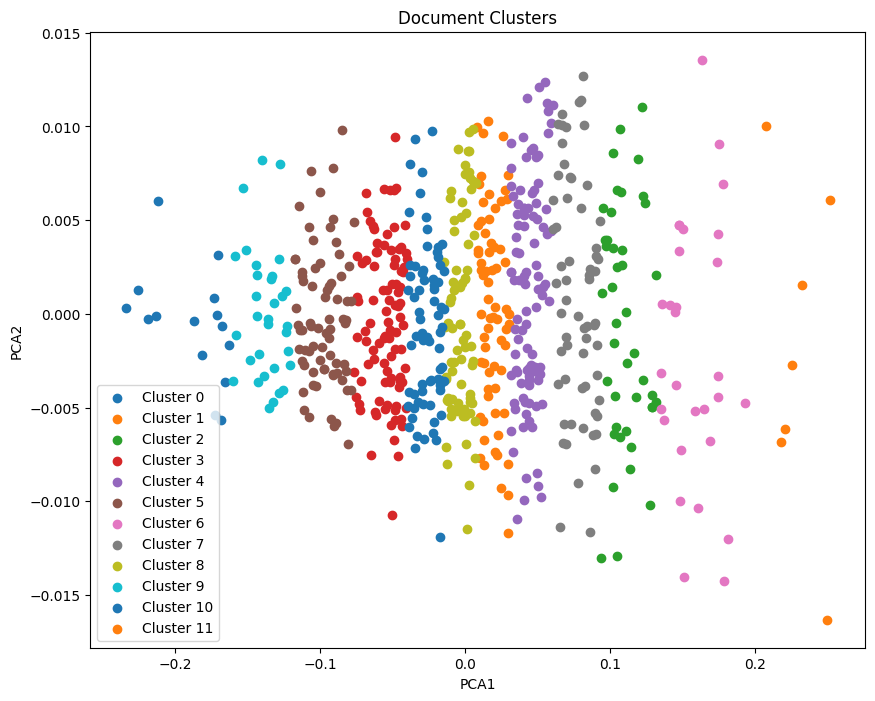

    class                                    RequirementText  Cluster
0      PE          system shall refresh display every second        2
1      LF  application shall match color schema set forth...        5
2      US  projected data must readable x projection scre...        3
3       A  product shall available normal business hour l...        1
4      US  projected data must understandable x projectio...        5
..    ...                                                ...      ...
669     O  system integrate multiple database management ...       10
670     O  system must installable operating environment ...        1
671    SE  system ensure company employee approved extern...        4
672    SE  manager able perform search query reservation ...        3
673    SE  system ensure database data corresponds exactl...        8

[674 rows x 3 columns]


In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

sentences = df['RequirementText'].apply(lambda x: x.split()).tolist()

word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def document_vector(doc, model):
    words = [word for word in doc if word in model.wv]
    if len(words) >= 1:
        return model.wv[words].mean(axis=0)
    else:
        return np.zeros(model.vector_size)

df['DocVector'] = df['RequirementText'].apply(lambda x: document_vector(x.split(), word2vec_model))

num_clusters = 12
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(list(df['DocVector']))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(list(df['DocVector']))

df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_points = df[df['Cluster'] == cluster]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], label=f'Cluster {cluster}')
plt.legend()
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Document Clusters')
plt.show()

print(df[['class', 'RequirementText', 'Cluster']])

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer, util

lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))

def process_requirement_text(text):
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower().split()
    review = [
        lemmatizer.lemmatize(word) if not word.isdigit() else word
        for word in review
        if word not in english_stopwords
    ]
    return ' '.join(review)

def read_requirements_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            parts = line.split(':', 1)
            if len(parts) == 2:
                data.append(parts)
            else:
                print(f"Skipping malformed line: {line}")
    return data

data_nfr = read_requirements_file('/content/sample_data/nfr.txt')
data_dup = read_requirements_file('/content/sample_data/nfr dup.txt')

df_nfr = pd.DataFrame(data_nfr, columns=["class", "requirement"])
df_dup = pd.DataFrame(data_dup, columns=["class", "requirement"])

df = pd.concat([df_nfr, df_dup], ignore_index=True)

df['RequirementText'] = df['requirement'].apply(process_requirement_text)

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

df['BERTEmbedding'] = list(model.encode(df['RequirementText'].tolist(), convert_to_tensor=False))

similarity_threshold = 0.8
df['SimilarRequirement'] = None

for i in range(len(df)):
    similar_reqs = []
    for j in range(i + 1, len(df)):
        sim_score = util.cos_sim(df['BERTEmbedding'][i], df['BERTEmbedding'][j]).item()
        if sim_score > similarity_threshold:
            similar_reqs.append(f"{df['RequirementText'][j]} (ID: {j})")
    if similar_reqs:
        df.at[i, 'SimilarRequirement'] = ', '.join(similar_reqs)

print(df[['class', 'RequirementText', 'SimilarRequirement']])

    class                                    RequirementText  \
0      PE          system shall refresh display every second   
1      LF  application shall match color schema set forth...   
2      US  projected data must readable x projection scre...   
3       A  product shall available normal business hour l...   
4      US  projected data must understandable x projectio...   
..    ...                                                ...   
669     O  system integrate multiple database management ...   
670     O  system must installable operating environment ...   
671    SE  system ensure company employee approved extern...   
672    SE  manager able perform search query reservation ...   
673    SE  system ensure database data corresponds exactl...   

                                    SimilarRequirement  
0        system refresh display every second (ID: 556)  
1    application shall match color schema set forth...  
2    projected data must understandable x projectio...  
3  

In [ ]:
df['SimilarRequirement'].count()

169